In [70]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [71]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [72]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [73]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)

In [74]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [75]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [76]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [77]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for col in columns:
    print(col['name'],col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [78]:
engine.execute('Select * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [79]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for col in columns:
    print(col['name'],col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [80]:
engine.execute('Select * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Precipitation Analysis

In [81]:
# Find the most recent date in the data set.

In [82]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


last_point = session.query(measurement.date).order_by(measurement.date.desc()).first()

last_point




('2017-08-23')

In [83]:
last_year = dt.date(2017,8,23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [84]:
# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year, measurement.prcp != None).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(year_prcp, columns=['Date','Precipitation'])
prcp_df.set_index('Date',inplace=True)
prcp_df.head()
# Sort the dataframe by date





,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


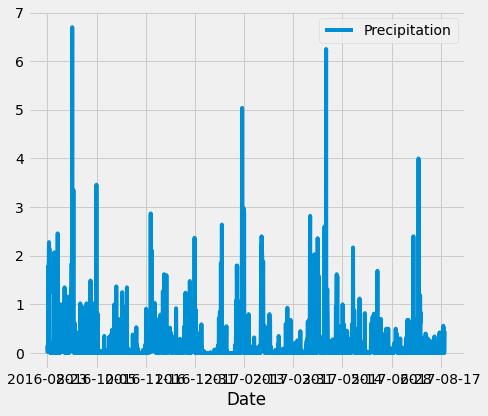

In [85]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(7,6))
plt.tight_layout()
plt.savefig('Images/Precipitation.png')

In [86]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [87]:
# Design a query to calculate the total number stations in the dataset
session.query(measurement.station).distinct().count()

9

In [88]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [89]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
summary_station = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').order_by(func.min(measurement.tobs)).all()

summary_station 

[(54.0, 85.0, 71.66378066378067)]

In [90]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(measurement.tobs).filter(measurement.date >= last_year, measurement.station == 'USC00519281').order_by(measurement.tobs).all()

active_temp_df = pd.DataFrame(year_temp,columns=['Temps'])
active_temp_df.head()

,Temps
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


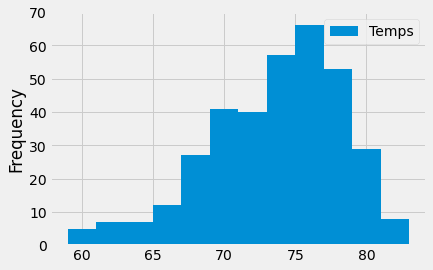

In [91]:
bins = 12
active_temp_df.plot.hist(year_temp,bins)
plt.ylim(0,70)
plt.savefig('Images/station_histo.png')

# Close session

In [92]:
# Close Session
session.close()